In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
# 获取2016年底沪深300成分股
时间 = '2016-12-31'
成分股 = get_index_stocks('000300.XSHG', 时间)

In [4]:
# 获取2016年底市盈率数据
数据 = get_fundamentals(query(valuation.code, valuation.pe_ratio).filter(
    valuation.code.in_(成分股)), statDate = '2016q4')

市盈率 = 数据['pe_ratio']

In [5]:
# 转换PE to EP
EP = 1/市盈率

# 中位数去极值（MAD）
def filter_extreme_MAD(series,n):
  median = series.median()
  mad = series.mad()
  max_range = median + n * mad
  min_range = median - n * mad
  return np.clip(series, min_range, max_range)

In [6]:
# 标准化
def standardize(series):
  std = series.std()
  mean = series.mean()
  return (series - mean) / std

In [7]:
# 股票回报
initial_prices =  get_price(成分股, start_date='2017-01-01', end_date='2017-03-31' , fields= 'close')
pct_return = (initial_prices['close'].iloc[-1]/initial_prices['close'].iloc[0] - 1) * 100

# 使用均值填充缺失值
pct_return.fillna(pct_return.mean(), inplace = True)

/opt/conda/lib/python3.6/site-packages/jqresearch/api.py:87: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  pre_factor_ref_date=_get_today())


Text(0, 0.5, 'Return')

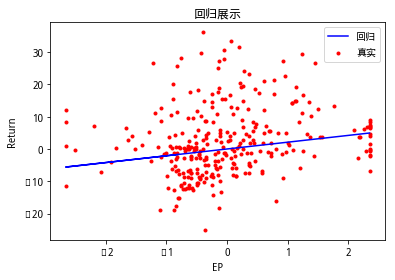

In [8]:
# 回归
y = pct_return.tolist()
x = standardize(filter_extreme_MAD(EP, 3)).tolist()

model = sm.OLS(y, x)
results = model.fit()
y_fit = results.predict()

plt.figure()
plt.scatter(x, y, c = 'r', marker = '.', label = '真实')
plt.plot(x, y_fit, 'b-',label = '回归')
plt.legend(loc = 'best')
plt.title('回归展示')
plt.xlabel('EP')
plt.ylabel('Return')